## 데이터 수집 및 데이터프레임 변환 후 저장 -> 전처리 -> Word2Vec

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import os
import nltk
import re

from tqdm import tqdm
tqdm.pandas()

In [ ]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### 데이터 불러오기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
tech_df = pd.read_csv('/content/drive/MyDrive/2023_멘토링(word2vec)/Data수집및가공/1113_tech_train_set_1195228.csv')
tech_df.head()

,sn,file_name,data_set,domain,subdomain,source,ko,mt,en,source_language,target_language,license,style
0,TNS20A12033,TFMACH3202001202120,기술과학,기계,의공학,한국학술정보,오븐 세척제에 포함된 피부 부식성/자극성 물질은 모두 심한 눈손상성/눈 자극성에도 ...,All skin corrosive/irritant substances contain...,All skin corrosion/irritation substances conta...,ko,en,open,문어체
1,TNS19D4694,연소전 처리를 이용한 탄소포집이 가스터빈 복합화력 플랜트의 성능에 미치는 영향,기술과학,전기,에너지,한국학술정보,국내에서는 2030년 BAU 대비 37%의 온실가스 감축을 의무화함으로써 이에 따른...,"In Korea, it is urgent to come up with a solut...","In Korea, it really is urgent to produce an an...",ko,en,open,문어체
2,MDS29B1055,Original Article Serum Anti-Mullerian Hormone ...,기술과학,의학,가정의학,한국학술정보,수술 전 정맥혈을 채취하고 월경주기의 난포기 동안 8시간 이상 금식한 후 정맥혈액을...,"Venous blood was collected before surgery, and...","Before the operation, blood samples were obtai...",en,ko,open,문어체
3,MDS21A6488,장기요양 인정자의 최초 재가급여 선택과 유지 및 이탈에 대한 영향요인 Aging i...,기술과학,의학,가정의학,한국학술정보,3등급 이하 인정자는 8.2%만이 재가급여에서 시설급여로 변경하였다.,Only 8.2% of those accredited for grade 3 or l...,Only 8.2% of third graders or lower changed fr...,ko,en,open,문어체
4,TNS01V13152,특허_16주_1020170079798,기술과학,기계,열처리,특허정보원,센싱에 의해 공기 중 오일입자가 기준치이하인지 여부를 판단할 수 있다.,"In addition, it is possible to determine wheth...",It is possible to determine whether or not the...,ko,en,open,문어체


In [ ]:
len(tech_df)

In [5]:
df = tech_df[['domain','mt','ko']]
df.head()

,domain,mt,ko
0,기계,All skin corrosive/irritant substances contain...,오븐 세척제에 포함된 피부 부식성/자극성 물질은 모두 심한 눈손상성/눈 자극성에도 ...
1,전기,"In Korea, it is urgent to come up with a solut...",국내에서는 2030년 BAU 대비 37%의 온실가스 감축을 의무화함으로써 이에 따른...
2,의학,"Venous blood was collected before surgery, and...",수술 전 정맥혈을 채취하고 월경주기의 난포기 동안 8시간 이상 금식한 후 정맥혈액을...
3,의학,Only 8.2% of those accredited for grade 3 or l...,3등급 이하 인정자는 8.2%만이 재가급여에서 시설급여로 변경하였다.
4,기계,"In addition, it is possible to determine wheth...",센싱에 의해 공기 중 오일입자가 기준치이하인지 여부를 판단할 수 있다.


In [6]:
new_df = df.iloc[:20000]
new_df

,domain,mt,ko
0,기계,All skin corrosive/irritant substances contain...,오븐 세척제에 포함된 피부 부식성/자극성 물질은 모두 심한 눈손상성/눈 자극성에도 ...
1,전기,"In Korea, it is urgent to come up with a solut...",국내에서는 2030년 BAU 대비 37%의 온실가스 감축을 의무화함으로써 이에 따른...
2,의학,"Venous blood was collected before surgery, and...",수술 전 정맥혈을 채취하고 월경주기의 난포기 동안 8시간 이상 금식한 후 정맥혈액을...
3,의학,Only 8.2% of those accredited for grade 3 or l...,3등급 이하 인정자는 8.2%만이 재가급여에서 시설급여로 변경하였다.
4,기계,"In addition, it is possible to determine wheth...",센싱에 의해 공기 중 오일입자가 기준치이하인지 여부를 판단할 수 있다.
...,...,...,...
19995,의학,The health teacher said that he could not do i...,보건 교사는 법적 책무성이 없어서 못 하겠다고 하며 회의가 끝났다.
19996,의학,It is difficult to say that it is the first ti...,정통 의학을 접하기 어려운 상황에서 효과 있는 처방을 중심으로 병세에 대처한 것은 ...
19997,ICT,Neues proposes the obligation to publish trans...,노이에스는 기업 서비스의 주요 알고리즘에 대한 투명성 리포트 발행 의무를 제안한다.
19998,기계,"Here, the processor 110 may be included in any...","여기에서, 프로세서(110)는 차량(100)에 설치된 다양한 디바이스들 중 어느 하..."


In [8]:
new_df.to_excel('/content/drive/MyDrive/2023_멘토링(word2vec)/word2vec_실습데이터_영한.xlsx', index=False)

In [9]:
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec

from tqdm.notebook import tqdm_notebook
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
new_df

,domain,mt,ko
0,기계,All skin corrosive/irritant substances contain...,오븐 세척제에 포함된 피부 부식성/자극성 물질은 모두 심한 눈손상성/눈 자극성에도 ...
1,전기,"In Korea, it is urgent to come up with a solut...",국내에서는 2030년 BAU 대비 37%의 온실가스 감축을 의무화함으로써 이에 따른...
2,의학,"Venous blood was collected before surgery, and...",수술 전 정맥혈을 채취하고 월경주기의 난포기 동안 8시간 이상 금식한 후 정맥혈액을...
3,의학,Only 8.2% of those accredited for grade 3 or l...,3등급 이하 인정자는 8.2%만이 재가급여에서 시설급여로 변경하였다.
4,기계,"In addition, it is possible to determine wheth...",센싱에 의해 공기 중 오일입자가 기준치이하인지 여부를 판단할 수 있다.
...,...,...,...
19995,의학,The health teacher said that he could not do i...,보건 교사는 법적 책무성이 없어서 못 하겠다고 하며 회의가 끝났다.
19996,의학,It is difficult to say that it is the first ti...,정통 의학을 접하기 어려운 상황에서 효과 있는 처방을 중심으로 병세에 대처한 것은 ...
19997,ICT,Neues proposes the obligation to publish trans...,노이에스는 기업 서비스의 주요 알고리즘에 대한 투명성 리포트 발행 의무를 제안한다.
19998,기계,"Here, the processor 110 may be included in any...","여기에서, 프로세서(110)는 차량(100)에 설치된 다양한 디바이스들 중 어느 하..."


In [40]:
eng_df = new_df.iloc[:, 1:2]
eng_df

,mt
0,All skin corrosive/irritant substances contain...
1,"In Korea, it is urgent to come up with a solut..."
2,"Venous blood was collected before surgery, and..."
3,Only 8.2% of those accredited for grade 3 or l...
4,"In addition, it is possible to determine wheth..."
...,...
19995,The health teacher said that he could not do i...
19996,It is difficult to say that it is the first ti...
19997,Neues proposes the obligation to publish trans...
19998,"Here, the processor 110 may be included in any..."


In [41]:
eng_df.to_excel('/content/drive/MyDrive/2023_멘토링(word2vec)/word2vec_실습데이터_영어.xlsx', index=False)

In [156]:
eng_df = pd.read_excel('/content/drive/MyDrive/2023_멘토링(word2vec)/word2vec_실습데이터_영어.xlsx')

In [157]:
eng_df[:5]

,mt
0,All skin corrosive/irritant substances contain...
1,"In Korea, it is urgent to come up with a solut..."
2,"Venous blood was collected before surgery, and..."
3,Only 8.2% of those accredited for grade 3 or l...
4,"In addition, it is possible to determine wheth..."


In [158]:
# 특수 문자 제거
eng_df['clean_mt'] = eng_df['mt'].str.replace("[^a-zA-Z]", " ")

# 길이가 2 이하인 단어는 제거 (길이가 짧은 단어 제거)
eng_df['clean_mt'] = eng_df['clean_mt'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# 전체 단어에 대한 소문자 변환
eng_df['clean_mt'] = eng_df['clean_mt'].apply(lambda x: x.lower())

<ipython-input-158-ede92a1824cf>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  eng_df['clean_mt'] = eng_df['mt'].str.replace("[^a-zA-Z]", " ")


In [159]:
eng_df

,mt,clean_mt
0,All skin corrosive/irritant substances contain...,all skin corrosive irritant substances contain...
1,"In Korea, it is urgent to come up with a solut...",korea urgent come with solution for this manda...
2,"Venous blood was collected before surgery, and...",venous blood was collected before surgery and ...
3,Only 8.2% of those accredited for grade 3 or l...,only those accredited for grade lower changed ...
4,"In addition, it is possible to determine wheth...",addition possible determine whether not the oi...
...,...,...
19995,The health teacher said that he could not do i...,the health teacher said that could not because...
19996,It is difficult to say that it is the first ti...,difficult say that the first time joseon socie...
19997,Neues proposes the obligation to publish trans...,neues proposes the obligation publish transpar...
19998,"Here, the processor 110 may be included in any...",here the processor may included any one variou...


In [160]:
# NULL 값 존재 유무
print(eng_df.isnull().values.any())

False


In [161]:
print(eng_df.isnull().values.sum())

0


In [162]:
eng_df = eng_df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(eng_df.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [163]:
# eng_df.replace("", float("NaN"), inplace=True)
# eng_df.isnull().values.any()

In [164]:
eng_df.dropna(inplace=True)
print('총 샘플 수 :',len(eng_df))

총 샘플 수 : 20000


In [165]:
!python3 -m nltk.downloader stopwords

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
eng_df['clean_mt']

0        all skin corrosive irritant substances contain...
1        korea urgent come with solution for this manda...
2        venous blood was collected before surgery and ...
3        only those accredited for grade lower changed ...
4        addition possible determine whether not the oi...
                               ...                        
19995    the health teacher said that could not because...
19996    difficult say that the first time joseon socie...
19997    neues proposes the obligation publish transpar...
19998    here the processor may included any one variou...
19999    whereas existing data centers focused providin...
Name: clean_mt, Length: 20000, dtype: object

In [179]:
# 불용어를 제거
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
tokenized_mt = eng_df['clean_mt'].apply(lambda x: x.split())
tokenized_mt = tokenized_mt.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_mt = tokenized_mt.to_list()

In [180]:
tokenized_mt

[['skin',
  'corrosive',
  'irritant',
  'substances',
  'contained',
  'oven',
  'cleaners',
  'also',
  'serious',
  'eye',
  'damage',
  'eye',
  'irritation'],
 ['korea',
  'urgent',
  'come',
  'solution',
  'mandatory',
  'reduce',
  'ghg',
  'emissions',
  'compared',
  'bau'],
 ['venous',
  'blood',
  'collected',
  'surgery',
  'fasting',
  'hours',
  'follicular',
  'phase',
  'menstrual',
  'cycle',
  'venous',
  'blood',
  'collected'],
 ['accredited',
  'grade',
  'lower',
  'changed',
  'home',
  'benefit',
  'facility',
  'benefit'],
 ['addition',
  'possible',
  'determine',
  'whether',
  'oil',
  'particles',
  'air',
  'reference',
  'value',
  'sensing'],
 ['specific',
  'bit',
  'bitmap',
  'rbg',
  'interpreted',
  'allocated',
  'first',
  'type',
  'terminal'],
 ['predetermined',
  'input',
  'may',
  'input',
  'forms',
  'closed',
  'curve',
  'including',
  'part',
  'handwriting',
  'input'],
 ['heat',
  'pipe',
  'heat',
  'transport',
  'device',
  'therma

In [181]:
print(len(tokenized_mt))

20000


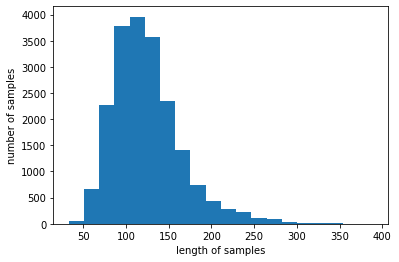

In [184]:
# 데이터 길이 확인

import matplotlib.pyplot as plt

plt.hist([len(s) for s in list(eng_df['mt'])], bins=20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# Word2Vec 훈련

size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원

window = 컨텍스트 윈도우 크기

negative = 네거티브 샘플링할 때 샘플 개수 지정 (0으로 두면 네거티브 샘플링 X, 네거티브 샘플링 진행 시 보통 5~20으로 지정)

min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)

workers = 학습을 위한 프로세스 수

sg = 0은 CBOW, 1은 Skip-gram

In [202]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_mt, size = 100, window = 5, negative = 5, min_count = 5, workers = 4, sg =1)

In [203]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(5465, 100)

In [205]:
print(model.wv.most_similar("symptoms"))

[('chronic', 0.9833160042762756), ('infection', 0.9802186489105225), ('tuberculosis', 0.9789777398109436), ('diseases', 0.9784994125366211), ('cardiovascular', 0.9783118963241577), ('complications', 0.9761766791343689), ('hepatocellular', 0.9751827716827393), ('pulmonary', 0.9748175740242004), ('hypertension', 0.972963273525238), ('lesions', 0.9729312658309937)]


In [206]:
model.save("eng_summary_word2vec.model")

In [207]:
vocabs = model.wv.vocab.keys()
vocabs

dict_keys(['skin', 'substances', 'contained', 'oven', 'also', 'serious', 'eye', 'damage', 'korea', 'urgent', 'come', 'solution', 'mandatory', 'reduce', 'emissions', 'compared', 'venous', 'blood', 'collected', 'surgery', 'fasting', 'hours', 'phase', 'menstrual', 'cycle', 'grade', 'lower', 'changed', 'home', 'benefit', 'facility', 'addition', 'possible', 'determine', 'whether', 'oil', 'particles', 'air', 'reference', 'value', 'sensing', 'specific', 'bit', 'interpreted', 'allocated', 'first', 'type', 'terminal', 'predetermined', 'input', 'may', 'forms', 'closed', 'curve', 'including', 'part', 'handwriting', 'heat', 'pipe', 'transport', 'device', 'thermal', 'conductivity', 'times', 'greater', 'high', 'metal', 'according', 'another', 'aspect', 'present', 'invention', 'apparatus', 'controlling', 'portable', 'provided', 'medical', 'institution', 'level', 'classified', 'risk', 'medium', 'low', 'devices', 'degree', 'caution', 'results', 'studies', 'renal', 'events', 'storage', 'communicate', 'h

In [208]:
word_vectors_list = [model.wv[v] for v in vocabs]

In [209]:
df_model = pd.DataFrame(list(model.wv.vocab.items()), columns=['word', 'vector'])
df_model['vector'] = word_vectors_list
df_model

,word,vector
0,skin,"[0.097346775, -0.25113, 0.21850105, 0.21863656..."
1,substances,"[0.101212114, -0.17791997, 0.17037226, 0.26781..."
2,contained,"[0.1416948, -0.2839429, 0.31005335, 0.20305781..."
3,oven,"[0.07259526, -0.21893422, 0.3396778, 0.2053949..."
4,also,"[0.07615277, -0.25242153, 0.22602086, 0.204607..."
...,...,...
5460,tear,"[0.09121325, -0.18862735, 0.25919136, 0.156269..."
5461,colitis,"[0.036345765, -0.1356073, 0.1484415, 0.1380291..."
5462,cqi,"[0.0850089, -0.16783433, 0.2621368, 0.12319374..."
5463,sec,"[0.02162504, -0.1437703, 0.20958625, 0.1218778..."


In [210]:
df_model.to_excel('/content/drive/MyDrive/2023_멘토링(word2vec)/eng_sum_vectors_arr.xlsx')

In [211]:
arr = np.zeros((5465, 100))
for idx, vector in enumerate(df_model['vector'].values):
    arr[idx, :] = vector

In [212]:
arr.shape

(5465, 100)

In [213]:
np.save('/content/drive/MyDrive/2023_멘토링(word2vec)/eng_sum_vectors_arr', arr)